In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torch
from torchvision import models, transforms

import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage import exposure


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
DENSENET121 = models.densenet121()
DENSENET121.classifier = nn.Sequential(
        nn.Linear(in_features=(DENSENET121.classifier.in_features),out_features=512),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512,out_features=256),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=256,out_features=128),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=128,out_features=2)
    )

In [4]:
model = DENSENET121
model = model.to(device)
model_config = torch.load('../models/V0/densenet121/2023-06-30 10:50:46.047269/best_model_config.pth.tar', map_location=device)
model.load_state_dict(model_config['model_weights'])
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
images = glob.glob('../data/chest_xray/train/PNEUMONIA/*')

In [14]:
sample_image = np.random.choice(images, 1)[0]

In [15]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

preprocess_normalize = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open(sample_image).convert("L").resize((256, 256))
img = np.array(img)
img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8)
img = np.stack((img, )*3) 
img = np.transpose(img, (1, 2, 0))


preprocess_img = preprocess(img)
input_batch = preprocess_normalize(preprocess_img)
input_batch = input_batch.unsqueeze(0)
input_batch = input_batch.to(device)

In [16]:
output = model(input_batch)
output = torch.softmax(output, dim=1)
output = torch.argmax(output, 1)

In [17]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input_batch, target=output, internal_batch_size=1, n_steps=50)

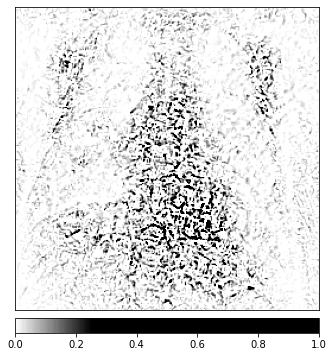

In [18]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(preprocess_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

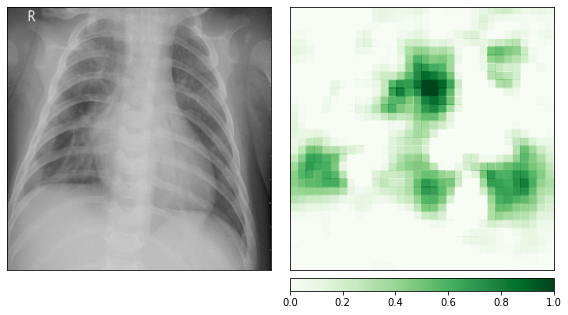

In [21]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_batch,
                                       strides = (3, 8, 8),
                                       target=output,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(preprocess_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

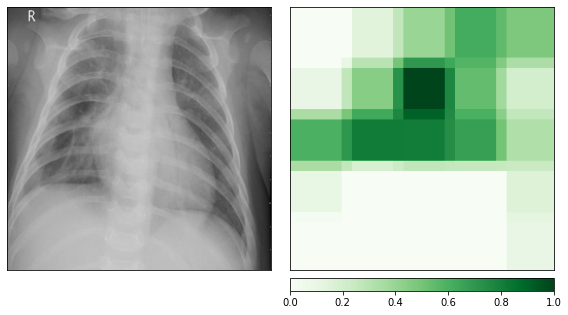

In [22]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_batch,
                                       strides = (3, 50, 50),
                                       target=output,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(preprocess_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )